---
# 0. 라이브러리
----

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from torchvision import transforms, datasets

from PIL import Image
from pprint import pprint
import easydict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # GPU 할당

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import librosa
from collections import Counter

In [3]:
cd /content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/

/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data


---
# 1. Data
----

In [4]:
class Config():
  train = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/train.csv'
  test = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/test.csv'
  sub = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/sample_submission.csv'
  epoch = 50
  train_epoch = 100
  lr = 5e-4
  sr = 16000
  batch_size = 64
  weight_decay_ae = 5e-6
  latent_dim = 200
  pretrain = True
  weight_decay = 5e-6
  lr_milestones = [25, 50, 75]

config = Config()

In [5]:
train = pd.read_csv(config.train)
test = pd.read_csv(config.test)
train

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0
...,...,...,...,...
1274,TRAIN_1274,./train/TRAIN_1274.wav,2,0
1275,TRAIN_1275,./train/TRAIN_1275.wav,2,0
1276,TRAIN_1276,./train/TRAIN_1276.wav,2,0
1277,TRAIN_1277,./train/TRAIN_1277.wav,2,0


---
# 2. Preprocessing
---

In [6]:
# FFT Code
def PositiveFFT(Input_rawdata,Sampling_frequency=16000, Length=16000):

    
    Fs = Sampling_frequency  # 시간 단위로 수집되는 신호의 샘플 수 / 높을수록 더 많은 샘플을 추출해 고해상도 디지털 신호가 생성되나 계산비용의 증가됨
    
    Input_rawdata = np.hanning(Length)*Input_rawdata # hanning window 적용 
                                                     # 스펙트럼의 누출을 줄이고 신호의 주파수 영역표현을 정확하게 하기 위해 사용
    L = len(Input_rawdata)  # 신호의 전체 길이
    
    X = Input_rawdata
    Y = np.fft.fft(X)  # 신호의 전체 FFT 반환
    
    N = int(len(Y)/2)
    Y =2*np.abs(Y[0:N])/(L/2) # FFT의 양의 주파수 성분만 선택 

    freq = np.linspace(0, Fs/2, N, endpoint=True) # FFT의 주파수의 배열인 freq를 생성하고 FFT와 주파수를 튜플로 반환
                                                  # 양의 주파수 성분에 해당하는 주파수 값 배열을 생성
    return (Y,freq)

In [7]:
def FFT_Result(Data):
    
    STRIDE=16000 # 한 번에 입력 신호에서 추출할 샘플 수를 정의
    Fs=16000 # 샘플링 주파수 
    
    sample = [Data[i:i+Fs] for i in range(0, len(Data), STRIDE)] 

    # 주파수 및 진폭의 값을 저장하는 리스트 생성
    F=[]
    A=[]
    for samp in sample:
        y, freq = PositiveFFT(samp) # 진폭 값, 주파수 값 반환
        A.append(y)
    
    F=freq
    A=np.array(A).mean(axis=0) # 모든 진폭값의 평균 계산 
    
    return F, A # 지정된 입력 신호에 대한 FFT의 주파수 및 진폭 값 반환

In [8]:
def get_feature(df):
    features = []
    for path in tqdm(df['SAMPLE_PATH']):
        # librosa패키지를 사용하여 wav 파일 load
        wav, sr = librosa.load(path, sr=config.sr)
        f, y = FFT_Result(wav)
        features.append(y)
    return np.array(features)

In [9]:
# mel
X_train = get_feature(train)
X_test = get_feature(test)
print(X_train.shape)
print(X_test.shape)

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

(1279, 8000)
(1514, 8000)


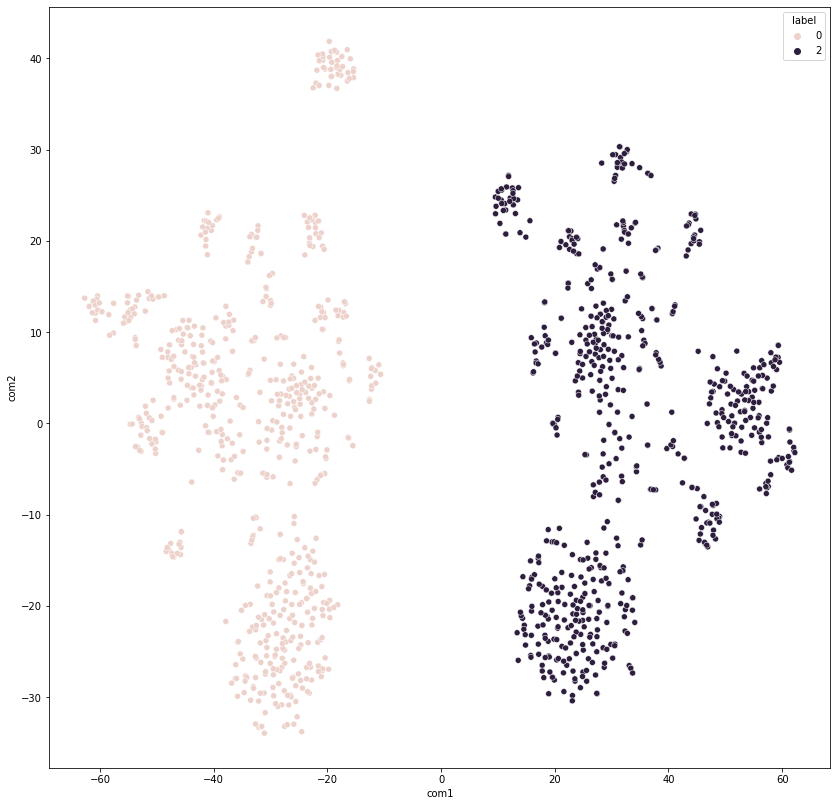

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tt = tsne.fit_transform(X_train)

tt_df = pd.DataFrame(tt, columns=['com1', 'com2'])
tt_df['label'] = train.iloc[:,2]

sns.set_palette('deep')
plt.figure(figsize=(14,14))
sns.scatterplot(x='com1', y='com2', hue='label', data=tt_df)

In [11]:
train_0, train_2 = [], []
for i, fan in enumerate(train.FAN_TYPE):
  if fan == 0:
    train_0.append(X_train[i])
  if fan == 2:
    train_2.append(X_train[i])

test_0, test_2 = [], []    
for i, fan in enumerate(test.FAN_TYPE):
  if fan == 0:
    test_0.append(X_test[i])
  if fan == 2:
    test_2.append(X_test[i])

In [12]:
train_0 = torch.tensor(train_0)
test_0 = torch.tensor(test_0)
train_2 = torch.tensor(train_2)
test_2 = torch.tensor(test_2)

In [13]:
ss0 = StandardScaler()
train_0 = torch.tensor(ss0.fit_transform(train_0)).float()
test_0 = torch.tensor(ss0.transform(test_0)).float()

ss2 = StandardScaler()
train_2 = torch.tensor(ss2.fit_transform(train_2)).float()
test_2 = torch.tensor(ss2.transform(test_2)).float()

In [14]:
print(len(train_0))
print(len(train_2))
print(len(test_0))
print(len(test_2))

639
640
779
735


---
# 3. Dataset & DataLoader
---

In [15]:
class custom_dataset(Dataset):
  
  def __init__(self, data):

    self.data = data

  def __len__(self):
    return len(self.data)
    

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.data[idx])
    return x


In [16]:
# train
train_0_dataset = custom_dataset(train_0)
train_2_dataset = custom_dataset(train_2)

# test
test_0_dataset = custom_dataset(test_0)
test_2_dataset = custom_dataset(test_2)


# train
train_0_loader = DataLoader(dataset = train_0_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)
train_2_loader = DataLoader(dataset = train_2_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)

# test
test_0_loader = DataLoader(dataset = test_0_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)
test_2_loader = DataLoader(dataset = test_2_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)

---
# 4. Model
----

In [17]:
class DeepSVDD_network(nn.Module):
    def __init__(self, latent_dim):
        super(DeepSVDD_network, self).__init__()
        self.latent_dim = latent_dim

        self.encoder_layer = nn.Sequential(
            nn.Linear(8000, 4000, bias = False),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(4000, 2000),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2000, 1000, bias = False),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1000, latent_dim),            
              )
        
    def forward(self, x):

        return self.encoder_layer(x)


class pretrain_autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(pretrain_autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder_layer = nn.Sequential(
            nn.Linear(8000, 4000, bias = False),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(4000, 2000),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2000, 1000, bias = False),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1000, latent_dim),      
                                         )
        
        self.decoder_layer = nn.Sequential(
            nn.Linear(latent_dim, 1000),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1000, 2000, bias = False),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2000, 4000),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(4000, 8000, bias = False),
        )      
    def encoder(self,x):
        return self.encoder_layer(x)

    def decoder(self,x):
        return self.decoder_layer(x)

    def forward(self, x):
        z = self.encoder_layer(x)
        x_hat = self.decoder_layer(z)
        return x_hat

In [18]:
# class DeepSVDD_network(nn.Module):
#     def __init__(self, latent_dim):
#         super(DeepSVDD_network, self).__init__()
#         self.latent_dim = latent_dim

#         self.encoder_layer = nn.Sequential(
#             nn.Linear(8000, 4000),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(4000, 2000),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(2000, 1000),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(1000, latent_dim),            
#             nn.ReLU(),
#               )
        
#     def forward(self, x):

#         return self.encoder_layer(x)


# class pretrain_autoencoder(nn.Module):
#     def __init__(self, latent_dim):
#         super(pretrain_autoencoder, self).__init__()
#         self.latent_dim = latent_dim

#         self.encoder_layer = nn.Sequential(
#             nn.Linear(8000, 4000),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(4000, 2000),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(2000, 1000),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(1000, latent_dim),            
#             nn.ReLU(),
#         )
        
#         self.decoder_layer = nn.Sequential(
#             nn.Linear(latent_dim, 1000),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(1000, 2000),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(2000, 4000),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(4000, 8000),
#         )      
#     def encoder(self,x):
#         return self.encoder_layer(x)

#     def decoder(self,x):
#         return self.decoder_layer(x)

#     def forward(self, x):
#         z = self.encoder_layer(x)
#         x_hat = self.decoder_layer(z)
#         return x_hat

---
# 5. Train
---

In [19]:
class TrainerDeepSVDD:
    def __init__(self, config, data_loader, device, path_dict):
        self.config = config
        self.train_loader = data_loader
        self.device = device
        self.path_dict = path_dict

    def pretrain(self):
        # 가중치 학습 단계
        ae = pretrain_autoencoder(self.config.latent_dim).to(self.device)
        ae.apply(weights_init_normal)
        optimizer = torch.optim.Adam(ae.parameters(), lr=self.config.lr,
                               weight_decay=self.config.weight_decay_ae)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=self.config.lr_milestones, gamma=0.2)
        
        ae.train()
        for epoch in range(self.config.train_epoch):
            total_loss = 0
            for x in tqdm(self.train_loader):
                x = x.float().to(self.device)
                
                optimizer.zero_grad()
                x_hat = ae(x)
                
                # scores = (x_hat - x) ** 2
                # reconst_loss = x_hat ** 2 + (1 / 0.1) * torch.mean(torch.max(torch.zeros_like(scores), scores))
                reconst_loss = torch.mean(torch.sum((x_hat - x) ** 2, dim=1))
                reconst_loss.backward()
                optimizer.step()
                
                total_loss += reconst_loss.item()
            scheduler.step()
            print('AutoEncoder /// Epoch: {}, Loss: {:.4f}'.format(epoch, total_loss/len(self.train_loader)))
        self.save_weights_for_DeepSVDD(ae, self.train_loader) 
    

    def save_weights_for_DeepSVDD(self, model, dataloader):
        # 학습된 AutoEncoder 가중치를 DeepSVDD모델에 Initialize
        c = self.set_c(model, dataloader)
        net = DeepSVDD_network(self.config.latent_dim).to(self.device)
        state_dict = model.state_dict()
        net.load_state_dict(state_dict, strict=False)
        torch.save({'center': c.cpu().data.numpy().tolist(),
                    'net_dict': net.state_dict()}, self.path_dict)
    

    def set_c(self, model, dataloader, eps=0.01):
        model.eval()
        z_ = []
        with torch.no_grad():
            for x  in tqdm(dataloader):
                x = x.float().to(self.device)
                z = model.encoder(x)
                z_.append(z.detach())
        z_ = torch.cat(z_)
        c = torch.mean(z_, dim=0)
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        return c

    def train(self):
        # Deep SVDD model 학습
        net = DeepSVDD_network(self.config.latent_dim).to(self.device)
        
        if self.config.pretrain==True:
            state_dict = torch.load(self.path_dict)
            net.load_state_dict(state_dict['net_dict'])
            c = torch.Tensor(state_dict['center']).to(self.device)
        else:
            net.apply(weights_init_normal)
            c = torch.randn(self.config.latent_dim).to(self.device)
        
        optimizer = torch.optim.Adam(net.parameters(), lr=self.config.lr,
                               weight_decay=self.config.weight_decay)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=self.config.lr_milestones, gamma=0.2)

        net.train()
        for epoch in range(self.config.epoch):
            total_loss = 0
            for x in tqdm(self.train_loader):
                x = x.float().to(self.device)

                optimizer.zero_grad()
                z = net(x)
                loss = torch.mean(torch.sum((z - c) ** 2, dim=1))
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
            scheduler.step()
            print('DeepSVDD /// Epoch: {}, Loss: {:.4f}'.format(epoch, total_loss/len(self.train_loader)))
        self.net = net
        self.c = c

        return self.net, self.c
        
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

In [20]:
fan_0 = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/pretrained_0.pt'
fan_2 = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/pretrained_2.pt'

# Network 학습준비, 구조 불러오기
deep_SVDD_0 = TrainerDeepSVDD(config, train_0_loader, device, fan_0)


# DeepSVDD를 위한 DeepLearning pretrain 모델로 Weight 학습
if config.pretrain:
    deep_SVDD_0.pretrain()

# 학습된 가중치로 Deep_SVDD모델 Train
net_0, c_0 = deep_SVDD_0.train()


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 0, Loss: 7276.8497


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 1, Loss: 5596.2995


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 2, Loss: 5256.0355


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 3, Loss: 5060.7595


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 4, Loss: 4916.0823


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 5, Loss: 4844.9181


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 6, Loss: 4777.5061


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 7, Loss: 4556.0994


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 8, Loss: 4396.5603


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 9, Loss: 4350.4688


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 10, Loss: 4246.7310


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 11, Loss: 4626.1444


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 12, Loss: 4292.8436


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 13, Loss: 4222.2024


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 14, Loss: 4305.0988


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 15, Loss: 4191.1486


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 16, Loss: 4251.7572


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 17, Loss: 4209.3759


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 18, Loss: 4404.9208


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 19, Loss: 4644.2126


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 20, Loss: 5146.6115


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 21, Loss: 4726.9865


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 22, Loss: 4582.0071


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 23, Loss: 4293.5103


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 24, Loss: 4060.8391


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 25, Loss: 4067.7902


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 26, Loss: 3940.9282


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 27, Loss: 4027.5025


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 28, Loss: 4007.0862


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 29, Loss: 3907.8465


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 30, Loss: 3910.2975


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 31, Loss: 3934.5719


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 32, Loss: 3932.8091


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 33, Loss: 3882.5870


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 34, Loss: 3886.2687


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 35, Loss: 3901.9193


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 36, Loss: 3872.9216


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 37, Loss: 3843.2604


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 38, Loss: 3869.2909


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 39, Loss: 3885.9027


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 40, Loss: 3835.3769


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 41, Loss: 3856.7301


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 42, Loss: 3847.4205


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 43, Loss: 3838.6291


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 44, Loss: 3821.9882


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 45, Loss: 3870.5867


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 46, Loss: 3845.7557


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 47, Loss: 3831.9475


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 48, Loss: 3802.2437


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 49, Loss: 3812.4412


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 50, Loss: 3816.4041


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 51, Loss: 3811.3098


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 52, Loss: 3774.0886


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 53, Loss: 3805.7188


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 54, Loss: 3763.5681


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 55, Loss: 3824.4804


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 56, Loss: 3820.8570


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 57, Loss: 3789.1949


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 58, Loss: 3762.3142


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 59, Loss: 3757.8613


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 60, Loss: 3785.7529


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 61, Loss: 3870.9725


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 62, Loss: 3785.9155


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 63, Loss: 3783.7338


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 64, Loss: 3763.4127


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 65, Loss: 3767.5209


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 66, Loss: 3757.6888


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 67, Loss: 3753.1383


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 68, Loss: 3746.5356


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 69, Loss: 3753.3952


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 70, Loss: 3796.8994


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 71, Loss: 3787.1657


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 72, Loss: 3785.1902


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 73, Loss: 3753.5629


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 74, Loss: 3774.5366


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 75, Loss: 3749.7891


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 76, Loss: 3759.1332


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 77, Loss: 3753.3039


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 78, Loss: 3786.3456


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 79, Loss: 3780.7010


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 80, Loss: 3735.9344


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 81, Loss: 3737.6306


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 82, Loss: 3752.9043


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 83, Loss: 3751.4035


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 84, Loss: 3761.1322


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 85, Loss: 3736.8171


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 86, Loss: 3732.7809


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 87, Loss: 3758.2249


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 88, Loss: 3755.9617


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 89, Loss: 3760.6763


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 90, Loss: 3765.8148


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 91, Loss: 3747.0489


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 92, Loss: 3775.7141


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 93, Loss: 3729.5531


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 94, Loss: 3733.5979


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 95, Loss: 3750.2753


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 96, Loss: 3773.9403


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 97, Loss: 3748.7579


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 98, Loss: 3733.5978


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 99, Loss: 3761.8723


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 0, Loss: 195.0080


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 1, Loss: 36.5949


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 2, Loss: 30.1210


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 3, Loss: 23.1608


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 4, Loss: 21.8261


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 5, Loss: 19.9315


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 6, Loss: 18.6337


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 7, Loss: 15.6891


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 8, Loss: 15.2697


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 9, Loss: 13.3373


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 10, Loss: 14.5235


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 11, Loss: 12.2540


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 12, Loss: 12.5368


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 13, Loss: 10.4076


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 14, Loss: 12.1255


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 15, Loss: 8.5168


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 16, Loss: 10.8256


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 17, Loss: 8.1240


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 18, Loss: 6.9587


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 19, Loss: 7.1020


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 20, Loss: 5.2443


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 21, Loss: 6.7204


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 22, Loss: 6.1675


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 23, Loss: 5.4182


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 24, Loss: 4.7871


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 25, Loss: 4.1834


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 26, Loss: 3.6655


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 27, Loss: 3.4953


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 28, Loss: 3.2785


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 29, Loss: 3.2626


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 30, Loss: 3.0416


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 31, Loss: 3.3416


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 32, Loss: 2.9142


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 33, Loss: 2.8278


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 34, Loss: 2.7335


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 35, Loss: 2.9291


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 36, Loss: 2.7752


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 37, Loss: 2.6289


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 38, Loss: 2.5806


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 39, Loss: 2.4973


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 40, Loss: 2.8541


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 41, Loss: 2.5014


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 42, Loss: 2.5009


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 43, Loss: 2.3224


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 44, Loss: 2.6015


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 45, Loss: 2.3006


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 46, Loss: 2.4410


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 47, Loss: 2.2800


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 48, Loss: 2.3023


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 49, Loss: 2.4868


In [21]:
deep_SVDD_2 = TrainerDeepSVDD(config, train_2_loader, device, fan_2)

if config.pretrain:
    deep_SVDD_2.pretrain()

net_2, c_2 = deep_SVDD_2.train()    

  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 0, Loss: 7923.0151


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 1, Loss: 7721.5055


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 2, Loss: 7571.5735


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 3, Loss: 7520.0756


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 4, Loss: 7429.1860


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 5, Loss: 7319.5769


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 6, Loss: 7248.3265


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 7, Loss: 7217.3740


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 8, Loss: 7194.0867


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 9, Loss: 7151.0143


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 10, Loss: 7123.6961


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 11, Loss: 7126.7919


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 12, Loss: 7226.5496


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 13, Loss: 7125.4342


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 14, Loss: 7095.1363


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 15, Loss: 7078.1993


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 16, Loss: 7145.8827


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 17, Loss: 7077.3302


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 18, Loss: 7079.4912


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 19, Loss: 7041.8235


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 20, Loss: 7065.5034


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 21, Loss: 7024.8613


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 22, Loss: 6974.3109


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 23, Loss: 6993.5542


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 24, Loss: 6976.0579


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 25, Loss: 6938.9311


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 26, Loss: 6888.2781


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 27, Loss: 6877.1700


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 28, Loss: 6857.2976


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 29, Loss: 6825.0599


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 30, Loss: 6806.5302


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 31, Loss: 6817.1922


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 32, Loss: 6801.5500


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 33, Loss: 6801.3925


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 34, Loss: 6787.8625


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 35, Loss: 6787.4580


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 36, Loss: 6782.5640


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 37, Loss: 6772.6164


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 38, Loss: 6753.1664


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 39, Loss: 6760.9826


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 40, Loss: 6734.5006


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 41, Loss: 6743.6394


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 42, Loss: 6725.4877


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 43, Loss: 6730.0790


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 44, Loss: 6720.4985


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 45, Loss: 6722.3115


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 46, Loss: 6703.8459


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 47, Loss: 6680.3457


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 48, Loss: 6709.8870


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 49, Loss: 6696.0172


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 50, Loss: 6678.0483


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 51, Loss: 6658.6688


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 52, Loss: 6658.7430


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 53, Loss: 6711.0561


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 54, Loss: 6664.1517


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 55, Loss: 6666.0926


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 56, Loss: 6660.7529


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 57, Loss: 6655.7094


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 58, Loss: 6663.5729


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 59, Loss: 6644.5734


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 60, Loss: 6652.4356


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 61, Loss: 6649.2228


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 62, Loss: 6642.5092


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 63, Loss: 6664.0837


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 64, Loss: 6653.4127


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 65, Loss: 6647.3126


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 66, Loss: 6638.9672


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 67, Loss: 6667.0305


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 68, Loss: 6634.8874


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 69, Loss: 6653.8478


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 70, Loss: 6654.2052


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 71, Loss: 6632.8264


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 72, Loss: 6634.4742


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 73, Loss: 6638.5709


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 74, Loss: 6632.5229


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 75, Loss: 6635.4428


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 76, Loss: 6633.7309


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 77, Loss: 6640.2392


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 78, Loss: 6644.7516


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 79, Loss: 6625.7828


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 80, Loss: 6634.5361


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 81, Loss: 6626.5072


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 82, Loss: 6624.6827


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 83, Loss: 6631.9146


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 84, Loss: 6624.1133


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 85, Loss: 6633.4733


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 86, Loss: 6631.8813


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 87, Loss: 6617.9601


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 88, Loss: 6620.5110


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 89, Loss: 6629.7199


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 90, Loss: 6631.4813


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 91, Loss: 6618.5400


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 92, Loss: 6620.0912


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 93, Loss: 6625.0035


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 94, Loss: 6641.7215


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 95, Loss: 6622.5646


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 96, Loss: 6632.5245


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 97, Loss: 6621.5207


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 98, Loss: 6617.0219


  0%|          | 0/10 [00:00<?, ?it/s]

AutoEncoder /// Epoch: 99, Loss: 6622.9422


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 0, Loss: 153.3562


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 1, Loss: 23.7655


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 2, Loss: 11.8446


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 3, Loss: 9.4726


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 4, Loss: 8.3626


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 5, Loss: 7.6128


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 6, Loss: 7.5754


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 7, Loss: 5.7815


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 8, Loss: 4.6451


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 9, Loss: 4.0825


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 10, Loss: 3.5674


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 11, Loss: 3.0705


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 12, Loss: 3.1560


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 13, Loss: 2.9062


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 14, Loss: 2.7972


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 15, Loss: 2.4179


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 16, Loss: 2.3434


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 17, Loss: 2.1276


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 18, Loss: 2.2340


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 19, Loss: 2.0079


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 20, Loss: 1.8314


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 21, Loss: 1.5876


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 22, Loss: 1.6139


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 23, Loss: 1.6086


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 24, Loss: 1.5001


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 25, Loss: 1.5556


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 26, Loss: 1.2759


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 27, Loss: 1.2875


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 28, Loss: 1.1538


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 29, Loss: 1.1198


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 30, Loss: 1.0337


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 31, Loss: 1.0395


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 32, Loss: 1.1408


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 33, Loss: 1.1000


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 34, Loss: 1.0500


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 35, Loss: 1.0091


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 36, Loss: 0.9873


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 37, Loss: 1.0278


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 38, Loss: 1.0828


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 39, Loss: 1.0391


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 40, Loss: 0.9426


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 41, Loss: 0.9061


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 42, Loss: 0.9210


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 43, Loss: 0.9385


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 44, Loss: 0.9645


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 45, Loss: 0.8759


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 46, Loss: 0.8751


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 47, Loss: 0.9011


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 48, Loss: 0.8927


  0%|          | 0/10 [00:00<?, ?it/s]

DeepSVDD /// Epoch: 49, Loss: 0.8599


---
# 6. Prediction
----

In [63]:
def eval(net, c, dataloader, device):
  scores = []
  net.eval()
  with torch.no_grad():
    for x in dataloader:
      x = x.float().to(device)
      z = net(x)
      score = torch.mean((z - c) ** 2, dim=1)
      scores.append(score.detach().cpu())
  scores = torch.cat(scores).numpy()
  return scores 

In [64]:
train_0_score = eval(net_0 ,c_0 ,train_0_loader, device)
train_2_score = eval(net_2 ,c_2 ,train_2_loader, device)

In [65]:
test_0_score = eval(net_0 ,c_0 ,test_0_loader, device)
test_2_score = eval(net_2 ,c_2 ,test_2_loader, device)

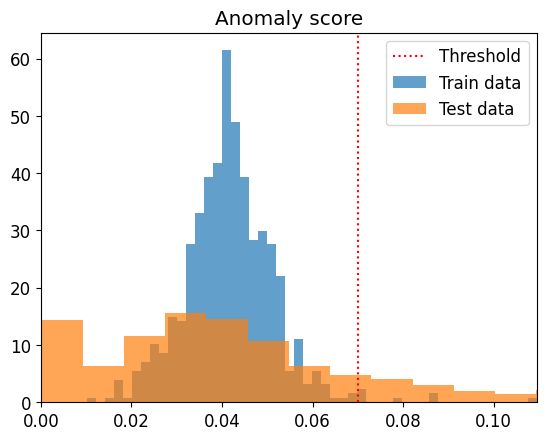

In [73]:
t_hold_0 = np.sort(np.array(train_0_score))[::-1]


for i, data in enumerate(t_hold_0):
    if(t_hold_0[i] - t_hold_0[i+1] < 0.001):
        Threshold_0 = data
        break

plt.style.use('default')
plt.rcParams['font.size'] = 12

plt.hist(train_0_score, bins=50, density=True, alpha=0.7, label='Train data')
plt.hist(test_0_score, bins=50, density=True, alpha=0.7, label='Test data')
plt.axvline(x=Threshold_0, c='red', linestyle=':', label='Threshold')
plt.title("Anomaly score")
plt.xlim(0, max(train_0_score))
plt.legend()

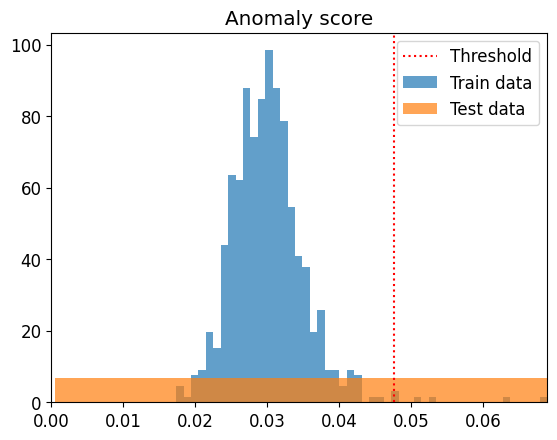

In [74]:
t_hold_2 = np.sort(np.array(train_2_score))[::-1]

for i, data in enumerate(t_hold_2):
    if(t_hold_2[i] - t_hold_2[i+1] < 0.001):
        Threshold_2 = data
        break

plt.style.use('default')
plt.rcParams['font.size'] = 12

plt.hist(train_2_score, bins=50, density=True, alpha=0.7, label='Train data')
plt.hist(test_2_score, bins=50, density=True, alpha=0.7, label='Test data')
plt.axvline(x=Threshold_2, c='red', linestyle=':', label='Threshold')
plt.xlim(0, max(train_2_score))
plt.title("Anomaly score")
plt.legend()

In [75]:
test_0 = np.zeros(len(test_0_score))
test_2 = np.zeros(len(test_2_score))

for i, value in enumerate(test_0_score):
    if value <= Threshold_0:
        test_0[i] = 0
    else:
        test_0[i] = 1

for i, value in enumerate(test_2_score):
    if value <= Threshold_2 :
        test_2[i] = 0
    else:
        test_2[i] = 1

In [76]:
n0 = -1
n2 = -1
Test_Result = []

for i, fan in enumerate(test.FAN_TYPE):
  if fan == 0:
      n0 += 1
      Test_Result.append(test_0[n0])
      
  if fan == 2:
      n2 += 1
      Test_Result.append(test_2[n2])

In [77]:
Counter(Test_Result)

Counter({0.0: 870, 1.0: 644})

---
# 7. Submisson
---

In [95]:
df = pd.DataFrame(np.array(Test_Result), columns = ['label'])

sub = pd.read_csv(config.sub)
sub['LABEL'] = df['label'].astype(int)
sub

,SAMPLE_ID,LABEL
0,TEST_0000,0
1,TEST_0001,1
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
1509,TEST_1509,1
1510,TEST_1510,1
1511,TEST_1511,0
1512,TEST_1512,0


In [90]:
qwe = pd.read_csv('/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/sub_0127(1).csv')
qwe['LABEL']

0       0.0
1       0.0
2       1.0
3       1.0
4       1.0
       ... 
1509    1.0
1510    1.0
1511    0.0
1512    0.0
1513    1.0
Name: LABEL, Length: 1514, dtype: float64

In [96]:
qwe['LABEL'].compare(df['label'])

,self,other
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
8,1.0,0.0
...,...,...
1503,1.0,0.0
1505,0.0,1.0
1506,1.0,0.0
1507,0.0,1.0


In [ ]:
sub.to_csv('/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/sub_0201_DeepSVDD.csv', index = False)